In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm

folder = 'data'
# rf_rate = 0.0467 #10yeartreasurybond (https://ycharts.com/indicators/10_year_treasury_rate)
rf_rate = 0.0

# Overview emperical assignment 1: 



## Problem 1. 
In this problem you are asked to analyse the five Fama-French asset
pricing factors (Mkt-Rf, SMB, HML, RMW, and CMA) discussed in “A fivefactor asset pricing model” by Fama and French (2015), as well as factors for
momentum (MOM) and short-term reversal (STREV). The data for the problem
can be found in the file “ap-2023-ff-data.xlsx,” which contains monthly factor
returns from Jan-1964 to Dec-2021

In [2]:
# data: 
df_ff = pd.read_excel(folder + "/ap-2023-ff-data.xlsx")
df_ff['Date'] = pd.to_datetime(df_ff['Year'].astype(str)+"-"+df_ff['Month'].astype(str), format = '%Y-%m')
df_ff.set_index('Date', inplace=True)
df_ff.drop(columns = ['Year', "Month"], inplace = True)
df_ff

,Mkt-RF,SMB,HML,RMW,CMA,MOM,STREV
Date,,,,,,,
1964-01-01,0.0224,0.0011,0.0147,0.0017,0.0151,0.0086,-0.0016
1964-02-01,0.0154,0.0030,0.0274,-0.0005,0.0090,0.0026,0.0019
1964-03-01,0.0141,0.0136,0.0336,-0.0221,0.0319,0.0075,0.0023
1964-04-01,0.0010,-0.0159,-0.0058,-0.0127,-0.0104,-0.0058,0.0345
1964-05-01,0.0142,-0.0064,0.0182,-0.0016,0.0014,0.0257,-0.0122
...,...,...,...,...,...,...,...
2021-08-01,0.0290,-0.0079,-0.0013,-0.0026,-0.0167,0.0252,-0.0155
2021-09-01,-0.0437,0.0125,0.0509,-0.0194,0.0208,0.0157,0.0079
2021-10-01,0.0665,-0.0269,-0.0044,0.0174,-0.0148,0.0321,-0.0161


,Mkt-RF,SMB,HML,RMW,CMA,MOM,STREV
Date,,,,,,,
2021-12-01,28.805129,3.820601,4.911609,5.677655,5.774985,39.123143,19.900478


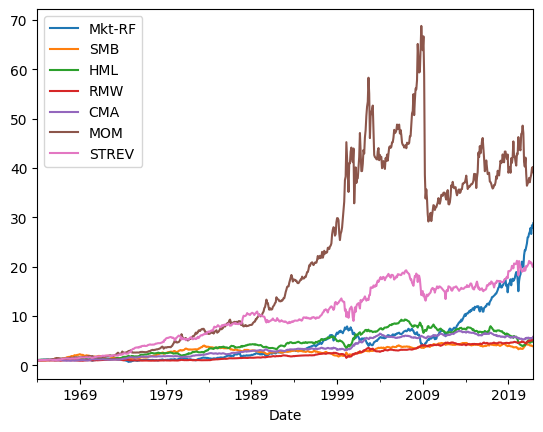

In [3]:
(df_ff+1).cumprod().plot()
(df_ff+1).cumprod()[-1:]


### Question a: 
Using the entire sample period, construct a portfolio from the Mkt-Rf, SMB,
and HML factors in such a way that (1) the Sharpe ratio of the portfolio
is maximized, (2) the portfolio weight of each factor is greater than or
equal to zero, (3) the portfolio weights sum up to one, and (4) the portfolio
weights do not change over time. What are the portfolio weights of the
different factors? What is the monthly Sharpe ratio of the portfolio? When
calculating and maximizing the Sharpe ratio, assume for simplicity that
the risk-free rate is zero.


Requirements: 
1. sharpe ratio maximized
2. portfolio weight greater or equal to 0
3. portfolio weight sum up to 1
4. portfolio weights do not change over time

Questions:
1. What are the portfolio weights of the different factors? 
2. What is the monthly Sharpe ratio of the portfolio? 

In [5]:
def MaximizeSharpeRatio(df, rf_rate):
    """"
    this function calculates the maximized sharpe ratio

    input: 
    - df (dataframe) normalized factors 
    - rf (riskfree rate) risk free rate

    output:
    - result (scipy.funciton) 
    """

    def calc_sharperatio(weights, df):
        """
        calculate sharpe ratio
        """
        factor_returns = df
        portfolio_return = np.sum(weights * factor_returns.mean())
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(df.cov(), weights)))
        sharpe_ratio = (portfolio_return - rf_rate)/portfolio_stddev
        return - sharpe_ratio

    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Weight sum constraint
    initial_weights = np.ones(len(df.columns)) /len(df.columns)
    bounds = tuple((0, 1) for _ in range(len(df.columns)))

    result = minimize(calc_sharperatio, initial_weights, args=(df,), method='SLSQP',
                      bounds=bounds, constraints=constraints)

    return result

df_ff_filtera = df_ff[['Mkt-RF', 'SMB', 'HML']]
results = MaximizeSharpeRatio(df_ff_filtera, rf_rate)
optimal_weights = results.x

portfolio_return = np.dot(optimal_weights, df_ff_filtera.mean())
portfolio_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(df_ff_filtera.cov(), optimal_weights)))
sharpe_ratio = (portfolio_return - rf_rate)/portfolio_stddev

print(f'Weights: {optimal_weights}, which sums up to {optimal_weights.sum()}')
print(f'Monthly sharpe ratio: {sharpe_ratio}')

Weights: [0.36988826 0.14652098 0.48359077], which sums up to 1.0
Monthly sharpe ratio: 0.1841350416429462


### Question b: 
Regress the RMW factor returns on the Mkt-Rf, SMB, and HML factors:

In [7]:
def calc_famafrench_factor_regression(X, Y_column = "HML"):
    Y = X[Y_column]
    X.drop(Y_column, axis = 1, inplace = True)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model.summary()

df_ff_filterb = df_ff[['Mkt-RF', 'SMB', 'HML', 'RMW']]
result = calc_famafrench_factor_regression(df_ff_filterb,Y_column = 'RMW')
result

C:\Users\bramg\AppData\Local\Temp\ipykernel_17508\1261136097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(Y_column, axis = 1, inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RMW   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     36.35
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           8.01e-22
Time:                        10:54:03   Log-Likelihood:                 1713.5
No. Observations:                 696   AIC:                            -3419.
Df Residuals:                     692   BIC:                            -3401.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.308      0.000       0.002       0.005
Mkt-RF        -0.0443      0.019     -2.359      0.019      -0.081      -0.007
SMB           -0.2361      0.027     -8.771      0.000      -0.289      -0.183
HML            0.0491      0.028      1.777      0.076      -0.005       0.103
==============================================================================
Omnibus:                       94.931   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1000.112
Skew:                           0.012   Prob(JB):                    6.74e-218
Kurtosis:                       8.872   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question c: 
Regress the CMA factor returns on the Mkt-Rf, SMB, and HML factors:


In [8]:
df_ff_filterb = df_ff[['Mkt-RF', 'SMB', 'CMA', 'RMW']]
result = calc_famafrench_factor_regression(df_ff_filterb,Y_column = 'CMA')
result

C:\Users\bramg\AppData\Local\Temp\ipykernel_17508\1261136097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(Y_column, axis = 1, inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CMA   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     41.01
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           2.12e-24
Time:                        10:54:04   Log-Likelihood:                 1797.7
No. Observations:                 696   AIC:                            -3587.
Df Residuals:                     692   BIC:                            -3569.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      5.648      0.000       0.003       0.005
Mkt-RF        -0.1742      0.016    -10.656      0.000      -0.206      -0.142
SMB           -0.0107      0.025     -0.428      0.669      -0.060       0.039
RMW           -0.0942      0.034     -2.803      0.005      -0.160      -0.028
==============================================================================
Omnibus:                       24.043   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.555
Skew:                           0.256   Prob(JB):                     1.56e-09
Kurtosis:                       4.066   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question d: 
Repeat the calculations in (a) using all five Fama-French factors. What are
the portfolio weights of the different factors? What is the monthly Sharpe
ratio of the portfolio? Briefly discuss the results in light of your results
from (b) and (c).

1. monthly sharpe ratio
2. portfolio weights

In [9]:
df_ff_filterd = df_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
results = MaximizeSharpeRatio(df_ff_filterd, rf_rate)
optimal_weights = results.x

portfolio_return = np.dot(optimal_weights, df_ff_filterd.mean())
portfolio_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(df_ff_filterd.cov(), optimal_weights)))
sharpe_ratio = (portfolio_return - rf_rate)/portfolio_stddev

print(f'Weights: {np.round(optimal_weights,2)}, which sums up to {np.round(optimal_weights.sum(),2)}')
print(f'Monthly sharpe ratio: {sharpe_ratio}')

Weights: [0.11 0.17 0.   0.34 0.38], which sums up to 1.0
Monthly sharpe ratio: -4.370884803503772


### Question e:
Regress the HML factor returns on the other Fama-French factors:

In [10]:
def calc_famafrench_factor_regression(X, Y_column = "HML"):
    Y = X[Y_column]
    X.drop(Y_column, axis = 1, inplace = True)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model.summary()

df_ff_filtere = df_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
result = calc_famafrench_factor_regression(df_ff_filtere, Y_column = "HML")
result

C:\Users\bramg\AppData\Local\Temp\ipykernel_17508\3895418914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(Y_column, axis = 1, inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    HML   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     153.1
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           9.62e-94
Time:                        10:54:05   Log-Likelihood:                 1695.2
No. Observations:                 696   AIC:                            -3380.
Df Residuals:                     691   BIC:                            -3358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.196      0.232      -0.003       0.001
Mkt-RF         0.0379      0.020      1.854      0.064      -0.002       0.078
SMB            0.0752      0.029      2.582      0.010       0.018       0.132
RMW            0.1896      0.039      4.839      0.000       0.113       0.267
CMA            1.0301      0.044     23.370      0.000       0.944       1.117
==============================================================================
Omnibus:                       92.741   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.418
Skew:                          -0.433   Prob(JB):                    2.67e-113
Kurtosis:                       7.138   Cond. No.                         56.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question f

In [11]:
df_ff_filterf = df_ff[['Mkt-RF', 'SMB', 'MOM', "HML",'RMW', 'CMA']]
result = calc_famafrench_factor_regression(df_ff_filterf, Y_column = "MOM")
result

C:\Users\bramg\AppData\Local\Temp\ipykernel_17508\3895418914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(Y_column, axis = 1, inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MOM   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     16.77
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.17e-15
Time:                        10:54:05   Log-Likelihood:                 1255.4
No. Observations:                 696   AIC:                            -2499.
Df Residuals:                     690   BIC:                            -2472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.002      4.463      0.000       0.004       0.010
Mkt-RF        -0.1617      0.039     -4.190      0.000      -0.237      -0.086
SMB            0.0391      0.055      0.710      0.478      -0.069       0.147
HML           -0.5255      0.072     -7.338      0.000      -0.666      -0.385
RMW            0.1901      0.075      2.534      0.011       0.043       0.337
CMA            0.3179      0.111      2.864      0.004       0.100       0.536
==============================================================================
Omnibus:                      225.911   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2316.223
Skew:                          -1.144   Prob(JB):                         0.00
Kurtosis:                      11.639   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question G

In [12]:
df_ff_filterg = df_ff[['Mkt-RF', 'SMB', 'STREV',"HML",'RMW', 'CMA']]
result = calc_famafrench_factor_regression(df_ff_filterg, Y_column = "STREV")
result

C:\Users\bramg\AppData\Local\Temp\ipykernel_17508\3895418914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(Y_column, axis = 1, inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  STREV   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     19.19
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           6.58e-18
Time:                        10:54:05   Log-Likelihood:                 1466.3
No. Observations:                 696   AIC:                            -2921.
Df Residuals:                     690   BIC:                            -2893.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.099      0.002       0.001       0.006
Mkt-RF         0.1877      0.028      6.587      0.000       0.132       0.244
SMB            0.0823      0.041      2.024      0.043       0.002       0.162
HML            0.2117      0.053      4.002      0.000       0.108       0.316
RMW           -0.0444      0.055     -0.802      0.423      -0.153       0.064
CMA           -0.2181      0.082     -2.660      0.008      -0.379      -0.057
==============================================================================
Omnibus:                      114.173   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1052.649
Skew:                           0.406   Prob(JB):                    2.63e-229
Kurtosis:                       8.970   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question h
Repeat the calculations in (a) using all seven factors. What are the portfolio
weights of the different factors? What is the monthly Sharpe ratio of the
portfolio?

In [13]:
df_ff_filterh = df_ff.copy()
results = MaximizeSharpeRatio(df_ff_filterh, rf_rate)
optimal_weights = results.x

portfolio_return = np.dot(optimal_weights, df_ff_filterh.mean())
portfolio_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(df_ff_filterh.cov(), optimal_weights)))
sharpe_ratio = (portfolio_return - rf_rate)/portfolio_stddev

print(f'Weights: {np.round(optimal_weights,2)}, which sums up to {np.round(optimal_weights.sum(),2)}')
print(f'Monthly sharpe ratio: {sharpe_ratio}')

Weights: [0.09 0.13 0.   0.27 0.33 0.08 0.09], which sums up to 1.0
Monthly sharpe ratio: -4.772289231914953


### Question I

In [14]:
df_ff.index
start_date = '1964-01-01'
end_date = '2000-01-01'
df_ff_filteri = df_ff[(df_ff.index >= start_date)&(df_ff.index <end_date)]

results = MaximizeSharpeRatio(df_ff_filteri, rf_rate)
optimal_weights = results.x

portfolio_return = np.dot(optimal_weights, df_ff_filteri.mean())
portfolio_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(df_ff_filteri.cov(), optimal_weights)))
sharpe_ratio = (portfolio_return - rf_rate)/portfolio_stddev

print(f'Weights: {np.round(optimal_weights,2)}, which sums up to {np.round(optimal_weights.sum(),2)}')
print(f'Monthly sharpe ratio: {sharpe_ratio}')

Weights: [0.06 0.1  0.04 0.36 0.29 0.07 0.07], which sums up to 1.0
Monthly sharpe ratio: -6.405723162244282


## Problem 2: 
In this problem you are asked to construct and analyse your own
asset pricing factor based on the illiquidity measure ILLIQ from “Illiquidity
and stock returns: cross-section and time-series effects” by Amihud (2002). The
data for the problem can be found in the file “ap-2023-amihud-data.xlsx,” which
contains daily dollar volumes of trade, daily returns, and monthly returns for
40 stocks, as well as monthly Fama-French-Carhart factor returns from Jan-1996
to Dec-2015. Each of the stocks is identified by a five-digit code that is derived
from the Center for Research in Security Prices (CRSP) database.


In [15]:
# data:
file_path = folder + "/ap-2023-amihud-data.xlsx"

returns_daily_df = pd.read_excel(file_path, sheet_name='returns-daily')
dollar_vols_daily_df = pd.read_excel(file_path, sheet_name='dollar-vols-daily')
returns_monthly_df = pd.read_excel(file_path, sheet_name='returns-monthly')
ff_factors_df = pd.read_excel(file_path, sheet_name='ff-factors')

returns_daily_df['Date'] = pd.to_datetime(returns_daily_df['Date'], format = '%Y-%m-%d')
returns_daily_df.set_index('Date', inplace = True)

dollar_vols_daily_df['Date'] = pd.to_datetime(dollar_vols_daily_df['Date'], format = '%Y-%m-%d')
dollar_vols_daily_df.set_index('Date', inplace = True)


returns_monthly_df['Date'] = pd.to_datetime(returns_monthly_df['Year'].astype(str)+"-"+returns_monthly_df['Month'].astype(str), format = '%Y-%m')
returns_monthly_df.set_index('Date', inplace=True)
returns_monthly_df.drop(columns = ['Year', "Month"], inplace = True)

ff_factors_df['Date'] = pd.to_datetime(ff_factors_df['Year'].astype(str)+"-"+ff_factors_df['Month'].astype(str), format = '%Y-%m')
ff_factors_df.set_index('Date', inplace=True)
ff_factors_df.drop(columns = ['Year', "Month"], inplace = True)

In [39]:
def calc_illq(returns_monthly_df, dollar_vols_daily_df):
    """
    calculate illiquidity of a stock or security

    input: 


    output: 
    
    
    """
    # to ensure taking the equally weighted average of the daily I LLIQ values in a given month we first ahve to sum each month
    monthly_volumes = dollar_vols_daily_df.resample('M').sum()
    # since the volumes are set to 31th of each month, we have to of set the month to 01 
    monthly_volumes.index = monthly_volumes.index.to_period('M').to_timestamp('M')
    monthly_volumes.index = monthly_volumes.index - pd.DateOffset(months=1)
    # aligning the monthly volumn with the monthly return
    monthly_volumes = monthly_volumes.reindex(returns_monthly_df.index, method='ffill')

    df_illiquidity = 10000000 *returns_monthly_df.abs() / monthly_volumes
    
    return df_illiquidity

df_illiquidity = calc_illq(returns_monthly_df, dollar_vols_daily_df)

# divides each illiquidity of each stock into 5 quantiles
nr_quant = 5
quintiles = df_illiquidity.apply(lambda x: pd.qcut(x, nr_quant, labels=False, duplicates='drop'), axis=1)

# Inverts the ranking of the quantiles (with the most illiquid stocks in quintile one and the most liquid stocks in quintile five.)
quintiles = quintiles.applymap(lambda x: 4 - x if not pd.isnull(x) else x)
quintiles

,10147,10890,11850,11891,15720,16600,17144,17750,17778,17929,...,49015,49154,49905,52038,52230,52695,52898,53065,60442,61313
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-01,1,0,4,0,2,1,4,4,4,0,...,3,4,3,3,3,2,0,2,3,0
1996-02-01,2,0,4,0,2,2,4,4,1,1,...,2,4,1,3,2,2,0,3,3,0
1996-03-01,4,2,4,0,3,3,3,4,2,1,...,1,2,1,4,0,2,0,0,4,0
1996-04-01,3,4,4,0,2,3,3,4,3,0,...,1,2,2,3,0,2,0,3,4,0
1996-05-01,3,0,4,1,2,2,3,4,0,0,...,2,3,3,2,1,2,0,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,3,0,4,3,4,3,4,2,1,0,...,1,4,1,3,1,4,3,0,3,0
2015-09-01,3,0,4,1,1,2,4,3,2,1,...,1,4,3,4,4,2,0,3,3,0
2015-10-01,4,0,4,1,3,3,3,2,1,1,...,1,4,1,2,2,3,0,0,4,0
